# Libraries and modules imports

In [ ]:
%load_ext autoreload
%autoreload 2

import torch 
print('Pytorch version :', torch.__version__)

from Class_PINN import PINN
from Class_CollocationPoints import CollocationPoints
from Class_ObservationPoints import ObservationPoints
from Backwater_model import J, compute_ref_solution
import display

Pytorch version : 2.0.1+cu117


# Cuda setup

In [2]:
# Device choice
use_GPU = False #Choose whether you want to use your GPU or not

if (torch.cuda.is_available() and use_GPU):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Running on {device} !')

#Additional info when using cuda
if (device.type == 'cuda'):
    print('GPU :', torch.cuda.get_device_name(0))
    print('Total memory :', 
          round(torch.cuda.get_device_properties(0).total_memory/1024**3, 1), 'GB')

#Set default usage to CPU or GPU
torch.set_default_device(device)

Running on cpu !


# $k_{true}$ definition

In [3]:
k_true = torch.tensor([45, 38, 28, 22, 30, 45, 60, 75]) #You can modify the value of k_true here !

# Collocation points definition

In [4]:
col = CollocationPoints(device, 
                        random = False, #Choose between grid collocation points (=True) and random collocation points (=False)
                        N_col = 100, #Choose number of collocation points
                        variable_boundaries = (0, 1000), #Choose the boundaries of the domain
                        test_size = 0, #Choose the testing set / training set ratio
                        seed = 0) #Set the seed to any integer number for reproductible randomness

# PINN definition

In [5]:
model = PINN(device, col = col,
             layers = [1, 40, 1], #Choose the neural network architecture
             k_0 = 40*torch.ones_like(k_true), #Choose the initialization value for k
             k_ref = 40, #Choose the reference value for scaling k
             k_interpolation = 'P1', #Choose the interpolation method for the k function (P1 or P0)
             seed = 0) #Set the seed to any integer number for reproductible randomness

# Reference solution and Observations generation

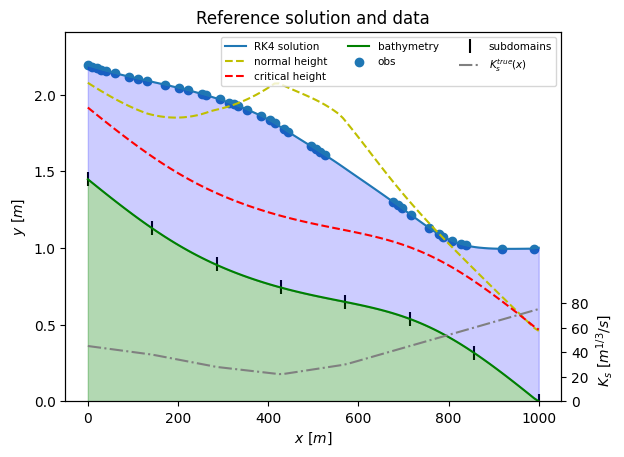

In [6]:
ref_solution = compute_ref_solution(model, col, k = k_true, dx = 10) 

obs = ObservationPoints(ref_solution, 
                        N_obs = 40, #Choose the number of observations in the domain
                        noise_std = 0, #Choose the standard deviation of the white noise added to the observations
                        seed = None) #Set the seed to any integer number for reproductible randomness

display.display_data(model, col, ref_solution, obs) 

# Model training 

##################################################
Processing iteration 50 (iter + eval = 62)
-------------------------
J           = 1.66e-04 (residual : 0.00e+00, BC : 1.59e-04, obs : 6.50e-06)
||grad(J)|| = 1.70e-02
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.])
time           = 0.42 s
##################################################
Processing iteration 100 (iter + eval = 123)
-------------------------
J           = 3.76e-05 (residual : 0.00e+00, BC : 3.66e-05, obs : 1.01e-06)
||grad(J)|| = 4.86e-03
parameter      = tensor([40., 40., 40., 40., 40., 40., 40., 40.])
time           = 0.90 s


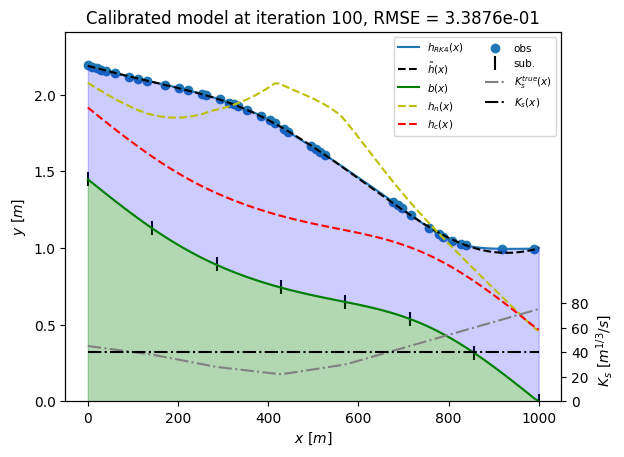

##################################################
Processing iteration 150 (iter + eval = 216)
-------------------------
J           = 4.73e-05 (residual : 1.04e-05, BC : 3.67e-05, obs : 1.84e-07)
||grad(J)|| = 5.56e-05
parameter      = tensor([46.7116, 37.4020, 27.2896, 22.1165, 28.7095, 45.9924, 58.7961, 52.8117])
time           = 1.69 s
##################################################
Processing iteration 200 (iter + eval = 273)
-------------------------
J           = 3.70e-05 (residual : 4.05e-06, BC : 3.28e-05, obs : 1.63e-07)
||grad(J)|| = 1.53e-04
parameter      = tensor([47.8663, 37.1111, 27.5769, 22.1888, 28.5964, 47.3375, 54.9462, 90.1394])
time           = 2.06 s


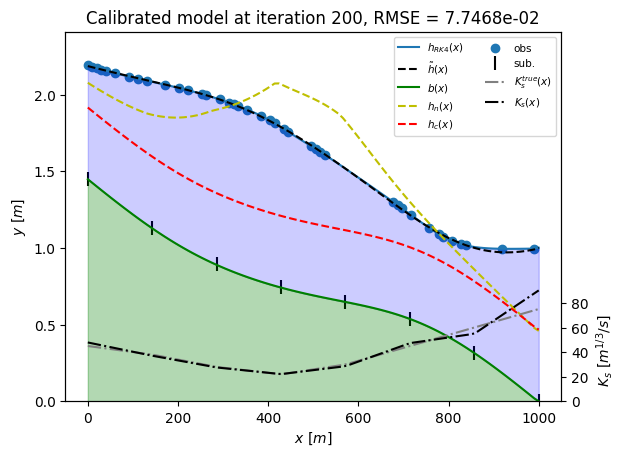

##################################################
Processing iteration 250 (iter + eval = 409)
-------------------------
J           = 3.60e-05 (residual : 3.65e-06, BC : 3.23e-05, obs : 1.04e-07)
||grad(J)|| = 2.63e-05
parameter      = tensor([48.0260, 37.3939, 27.1480, 22.6077, 28.3732, 46.8191, 55.8723, 89.9572])
time           = 3.07 s
##################################################
Processing iteration 300 (iter + eval = 582)
-------------------------
J           = 3.63e-05 (residual : 3.60e-06, BC : 3.27e-05, obs : 1.44e-08)
||grad(J)|| = 6.52e-03
parameter      = tensor([47.3221, 37.5903, 27.2520, 22.4794, 28.4163, 47.1023, 55.7440, 89.6918])
time           = 4.20 s


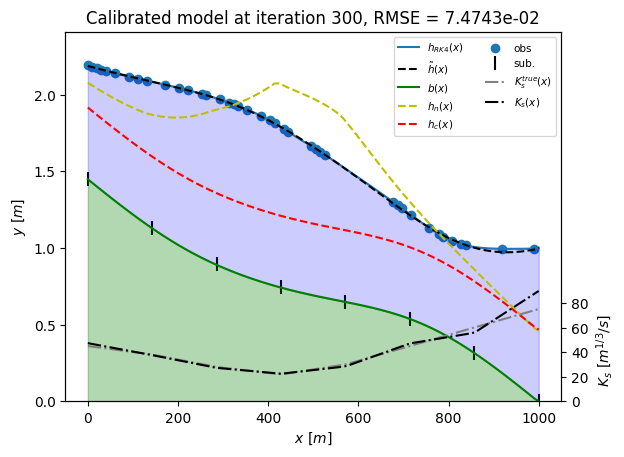

In [7]:
model.train_model(J, col, obs, ref_solution, 
                  normalize_J = True, #Choose whether you want to normalize J by J_0 or not
                  pre_train_iter = 100, #Choose the number of iterations for pre-training
                  alter_steps = 4, #Choose the number of alternating minimization steps
                  alter_freq = (40, 10), #Choose the number of iterations on theta (first value) and on k (second value) for each step
                  display_freq = (50, 100)) #Choose the display frequency for the training informations (first value) and the results plot (second value)

# Display training and results

##################################################
Final parameter RMSE : 7.47e-02
Final variable RMSE : 8.14e-03
##################################################


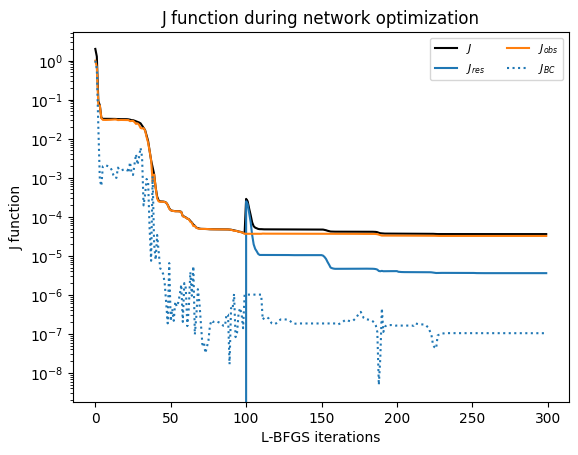

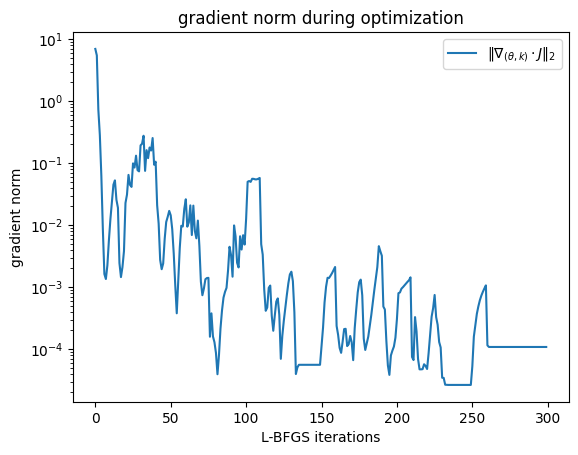

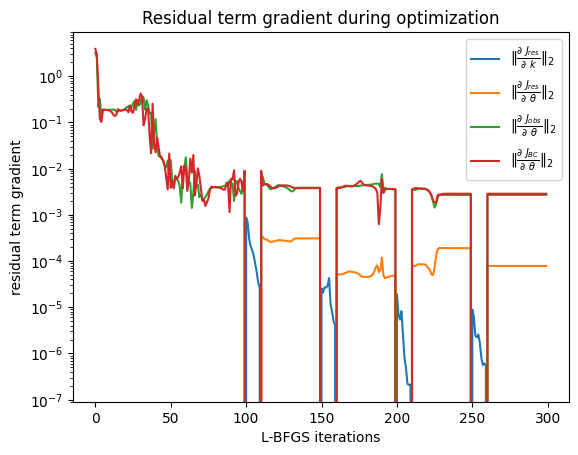

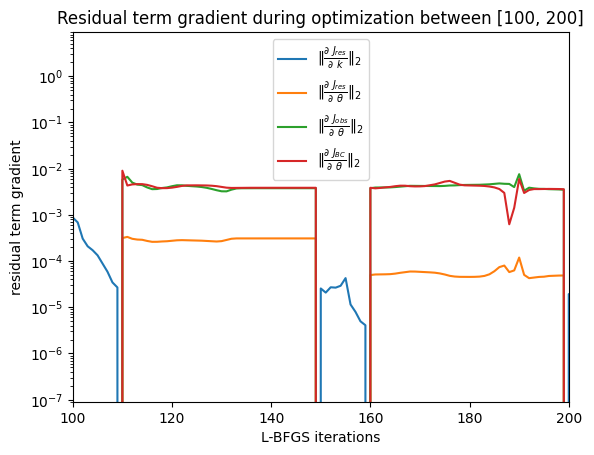

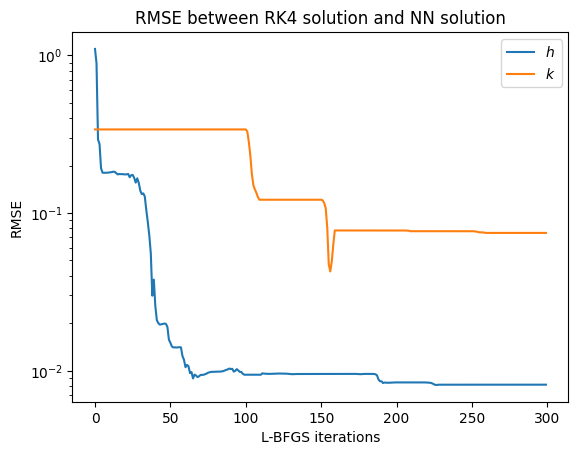

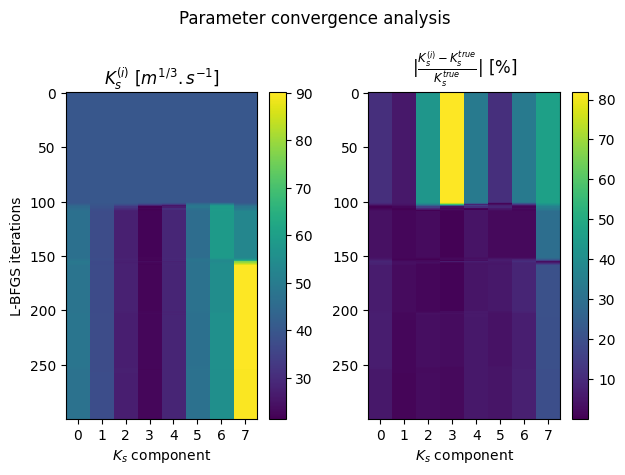

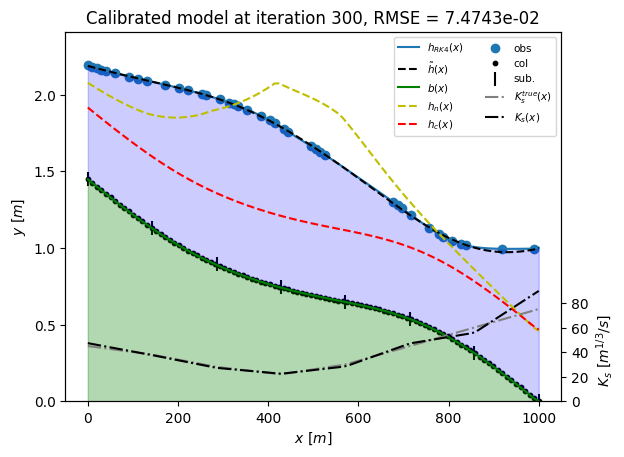

In [8]:
display.display_training(model, col, ref_solution)

display.display_results(model, col, ref_solution, obs, plot_col = True)